# **Environment Setup**

In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [ ]:
!pip install py7zr

In [ ]:
!pip install tensorflow -U

In [1]:
from zipfile import ZipFile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio,Image
import os
from PIL import Image

In [ ]:
!pip install tensorflow==2.10
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

# **Import from Kaggle**

In [6]:
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

time: 665 ms (started: 2022-09-16 06:47:18 +00:00)


In [7]:
!kaggle competitions download -c 'tensorflow-speech-recognition-challenge'

100% 3.49G/3.50G [00:34<00:00, 167MB/s]
100% 3.50G/3.50G [00:34<00:00, 110MB/s]
time: 35.1 s (started: 2022-09-16 06:47:19 +00:00)


In [8]:
with ZipFile("/content/tensorflow-speech-recognition-challenge.zip","r") as zip_ref:
  zip_ref.extractall("/content/dataset")

time: 28.9 s (started: 2022-09-16 06:47:54 +00:00)


In [9]:
!py7zr x /content/dataset/train.7z

time: 8min 47s (started: 2022-09-16 06:48:23 +00:00)


# **Data Processing**

In [4]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

**Wav to Spectrogram**

In [16]:
def load_wav(wav_path):
  wav = tf.io.read_file(wav_path)
  waveform = tf.audio.decode_wav(wav, desired_channels=1)
  return waveform.audio



def wav_to_spectrogram(signal,width=128,height=128,frame_length=1024,frame_step=256,brightness=100.):
  signal = tf.transpose(signal)
  stfts = tf.signal.stft(signal,frame_length,frame_step)
  spectrogram = tf.abs(stfts)

  brightness = tf.constant(brightness)
  mul = tf.multiply(spectrogram,brightness)
  min_const = tf.constant(255.)
  minimum = tf.minimum(mul,min_const)

  expand_dims = tf.expand_dims(minimum,-1)

  resize = tf.image.resize(expand_dims,[width,height])

  squeeze = tf.squeeze(resize,0)

  flip_left_right = tf.image.flip_left_right(squeeze)
  transposed = tf.image.transpose(flip_left_right)

  vmin = tf.reduce_min(transposed)
  vmax = tf.reduce_max(transposed)

  return (transposed - vmin) / (vmax - vmin)


def colorize(value, cmap=None):
        value = tf.squeeze(value)

        # quantize
        indices = tf.cast(tf.round(value * 255), dtype=tf.int32)

        # gather
        cm = plt.get_cmap(cmap if cmap is not None else 'gray')
        colors = cm(np.arange(256))[:, :3]
        colors = tf.constant(colors, tf.float32)
        value = tf.gather(colors, indices)


        return tf.clip_by_value(value,clip_value_min=0,clip_value_max = 1)


def to_png(data):
  return tf.io.encode_png(tf.cast(data.numpy() * 255.0, tf.uint8))


time: 3.59 ms (started: 2022-09-16 07:19:23 +00:00)


In [17]:
def convert_in_dir(dir):
  counter = 0
  subdirs = [subdir.path for subdir in os.scandir(dir) if subdir.is_dir()]
  for subdir in subdirs:
    files = [wav.path for wav in os.scandir(subdir) if wav.is_file() and ".wav" in wav.path]
    for wav in files:
      filename = wav.replace("wav","png")
      try:
        audio = load_wav(wav)
        audio = wav_to_spectrogram(audio,width=IMAGE_WIDTH,height=IMAGE_HEIGHT)
        audio = colorize(audio,cmap="jet")
        audio = to_png(audio)
        tf.io.write_file(filename,audio)
        print(filename)
      except:
        print(filename+" can't be converted!")

      counter+=1
      print(counter)
      

time: 1.74 ms (started: 2022-09-16 07:19:26 +00:00)


In [14]:
# def clean(dir):
#   counter = 0
#   subdirs = [subdir.path for subdir in os.scandir(dir) if subdir.is_dir()]
#   for subdir in subdirs:
#     files = [wav.path for wav in os.scandir(subdir) if wav.is_file() and ".png" in wav.path]
#     for wav in files:
#       os.remove(wav)

# clean("/content/train/audio")

time: 1.87 s (started: 2022-09-16 07:18:58 +00:00)


In [ ]:
convert_in_dir("/content/train/audio")

**Train,Validation and Test Set Building**

In [2]:
train_set = tf.keras.utils.image_dataset_from_directory("/content/train/audio",
                                                        validation_split = 0.2,
                                                        seed = 25,
                                                        subset = "training",
                                                        image_size=[IMAGE_HEIGHT,IMAGE_WIDTH],
                                                        label_mode = "categorical"
                                                        )
validation_set = tf.keras.utils.image_dataset_from_directory("/content/train/audio",
                                                        validation_split = 0.2,
                                                        seed = 25,
                                                        subset = "validation",
                                                        image_size=[IMAGE_HEIGHT,IMAGE_WIDTH],
                                                        label_mode = "categorical"
                                                        )

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Found 64727 files belonging to 31 classes.
Using 12945 files for validation.


In [3]:
validation_cardinality = tf.data.experimental.cardinality(validation_set)
test_set = validation_set.take(validation_cardinality // 5)
validation_set = validation_set.skip(validation_cardinality // 5)

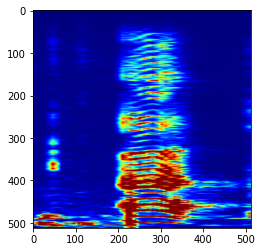

time: 3.31 s (started: 2022-09-16 08:13:33 +00:00)


In [21]:
plt.imshow(train_set.as_numpy_iterator().next()[0][8]/255.)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

# **Training and Testing**

In [5]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1/255.,input_shape = [IMAGE_HEIGHT,IMAGE_WIDTH,3]),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(31,activation="softmax")
])

In [6]:
model.compile(optimizer="adam",loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
model.summary()

In [7]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,verbose=1,restore_best_weights=True)
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",patience=3,verbose=1)

In [ ]:
history = model.fit(train_set,epochs=60,validation_data=(validation_set),callbacks=[earlystopping,lr_plateau]) 

In [35]:
model.evaluate(test_set)

81/81 [==============================] - 2s 25ms/step - loss: 0.3713 - accuracy: 0.9005 - precision_2: 0.9398 - recall_2: 0.8792


[0.37134310603141785,
 0.9004629850387573,
 0.9397938251495361,
 0.8792438507080078]